Code for 
# "Exploration of Latent Representations Generated by a Neural Network from Piano Music"

made in the context of *Undergraduate Research Program @ UC Chile - School of Engineerin,*

#### by **Javier Campos**

#### Advisors: **Marcelo Mendoza (CS) and Rodrigo Cádiz (EE)**

# Data processing

In [67]:
import pandas as pd
import os
import shutil
from tqdm.auto import tqdm

In [11]:
# Load the CSV file
csv_path = 'maestro-v3/maestro-v3.0.0/maestro-v3.0.0.csv'
df = pd.read_csv(csv_path)

In [12]:
#directories
maestro_base_dir = 'maestro-v3/maestro-v3.0.0'
output_base_dir = 'Temas'

Create split folders

In [13]:
for split in ['train', 'test', 'validation']:
    os.makedirs(os.path.join(output_base_dir, split), exist_ok=True)

In [14]:
tqdm.pandas()

remove symbols from the compositions names

In [15]:
import re

def remove_symbols(input):
    clean = re.sub(r'[^\w\s]', '', input)
    return clean

Spilit the dataset

In [16]:
# Process each split
for split in ['train', 'test', 'validation']:
    split_df = df[df['split'] == split]
    split_dir = os.path.join(output_base_dir, split)
    
    # Copy audio files to the respective split directory
    for _, row in tqdm(split_df.iterrows()):
        audio_src = os.path.join(maestro_base_dir, row['audio_filename'])
        composer = row['canonical_composer']
        composer = remove_symbols(composer).strip()
        title = row['canonical_title']
        title = remove_symbols(title).strip()
        audio_dst = os.path.join(split_dir, os.path.basename(composer+'$'+title+'.wav'))
        try:
            shutil.copy(audio_src, audio_dst)
        except OSError:
            print(f"Error copying {audio_src} to {audio_dst}")

962it [01:51,  8.61it/s]
177it [00:15, 11.66it/s]
137it [00:14,  9.27it/s]


# Encoder!

In [5]:
from transformers import EncodecModel, AutoProcessor
import numpy as np
import matplotlib.pyplot as plt

In [6]:
model_id = "facebook/encodec_48khz"
model = EncodecModel.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)

c:\Users\javie\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\encodec\modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


In [7]:
import torch

In [8]:
#check cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
model.to(device)


EncodecModel(
  (encoder): EncodecEncoder(
    (layers): ModuleList(
      (0): EncodecConv1d(
        (conv): Conv1d(2, 32, kernel_size=(7,), stride=(1,))
        (norm): GroupNorm(1, 32, eps=1e-05, affine=True)
      )
      (1): EncodecResnetBlock(
        (block): ModuleList(
          (0): ELU(alpha=1.0)
          (1): EncodecConv1d(
            (conv): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
            (norm): GroupNorm(1, 16, eps=1e-05, affine=True)
          )
          (2): ELU(alpha=1.0)
          (3): EncodecConv1d(
            (conv): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
            (norm): GroupNorm(1, 32, eps=1e-05, affine=True)
          )
        )
        (shortcut): EncodecConv1d(
          (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
          (norm): GroupNorm(1, 32, eps=1e-05, affine=True)
        )
      )
      (2): ELU(alpha=1.0)
      (3): EncodecConv1d(
        (conv): Conv1d(32, 64, kernel_size=(4,), stride=(2,))
        (norm): Group

In [23]:
#feature extraction
def extract_features(audio):
    inputs = processor(audio, sampling_rate=processor.sampling_rate, return_tensors="pt")
    inputs.to(device)
    encoder_outputs = model(inputs["input_values"], inputs["padding_mask"]).audio_codes.squeeze()
    encoder_outputs = encoder_outputs.cpu()
    return encoder_outputs.flatten().numpy()

In [11]:
from scipy.io import wavfile

In [25]:
#audio clip duration in seconds
d = 10

In [12]:
def read_audio(audio_path):
    sr, audio = wavfile.read(audio_path)
    audio = audio.T
    audio = audio[:,:sr*d]
    return audio

In [15]:
from tqdm.auto import tqdm
import os

In [ ]:
for split in ['train', 'test', 'validation']:
   folder = 'Temas/'+split
   save_folder = 'features/'+split
   os.makedirs(save_folder, exist_ok=True)
   list_dir = os.listdir(folder)
   for audio_file in tqdm(list_dir):
       audio_path = os.path.join(folder, audio_file)
       audio = read_audio(audio_path)
       features = extract_features(audio)
       save_path = os.path.join(save_folder, audio_file.strip('.wav'))
       np.save(save_path, features)

# Analysis

## Pre-process
Maybe be necessary to restar the environment here!

In [3]:
features = []
labels = []

In [4]:
import numpy as np
import os
for split in ['train', 'test', 'validation']:
    folder_path = 'features/'+split
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".npy"): #check file extension
            filepath = os.path.join(folder_path, file_name)
            data = np.load(filepath)
            if data.shape[0] == 3000: #verify shape
                composer, song_name = file_name.split('$')
                features.append(data)
                labels.append(composer)



In [83]:
# Convert the list of features and labels to a NumPy array
features = np.array(features)
labels = np.array(labels)

As we are not finetuning, we can aggregate all data in one matrix

In [15]:
os.makedirs('Mat', exist_ok=True)

In [85]:
np.save('Mat/ft_all.npy', features)
np.save('Mat/lb_all.npy', labels)

## Dimensionality reduction!

Here you can safely restart the environment for RAM svaing purpuses

In [9]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import pandas as pd


In [5]:
features = np.load('Mat/ft_all.npy')

In [7]:
features.shape

(809, 3000)

Here, we first reduce dimensionality with PCA as it is recommended by sklearn docs for tSNE.

The number of dimensions (60) was adjusted manually. It equals 2% of the original dimensions.

Perplexity=12 was also set manually, by observing the visualization.  

In [19]:
# Reduce to 60 dimensions using PCA
pca = PCA(n_components=60)
features_pca = pca.fit_transform(features)

# Alternatively, use t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, perplexity=12, random_state=42) #15
features_tsne = tsne.fit_transform(features_pca)


In [11]:
features_pca.shape

(809, 60)

In [12]:
features_tsne.shape

(809, 2)

In [13]:
labels = np.load('Mat/lb_all.npy')
labels = labels.tolist()

## Plots

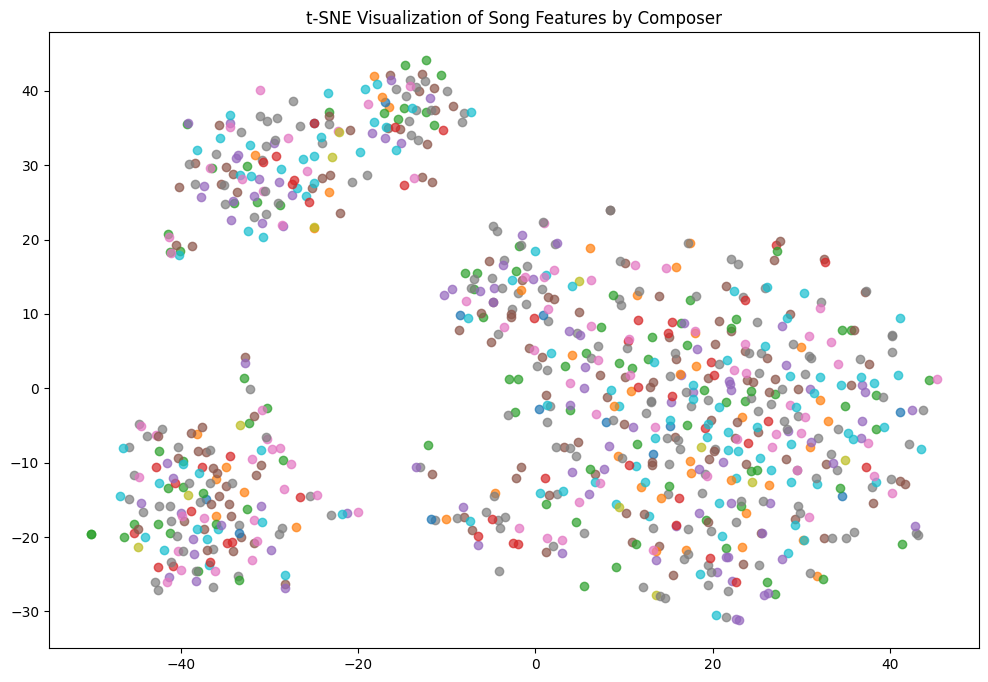

In [32]:
# Convert to a DataFrame for easier visualization
df = pd.DataFrame(features_tsne, columns=['x', 'y'])
df['composer'] = labels

# Plot using Matplotlib
plt.figure(figsize=(12, 8))
for composer in df['composer'].unique():
    subset = df[df['composer'] == composer]
    plt.scatter(subset['x'], subset['y'], label=composer, alpha=0.7)

#plt.xlabel('Component 1')
#plt.ylabel('Component 2')
plt.title('t-SNE Visualization of Song Features by Composer')
plt.savefig('imgs/fig1.png')
#plt.legend()
plt.show()


Plot with composers names

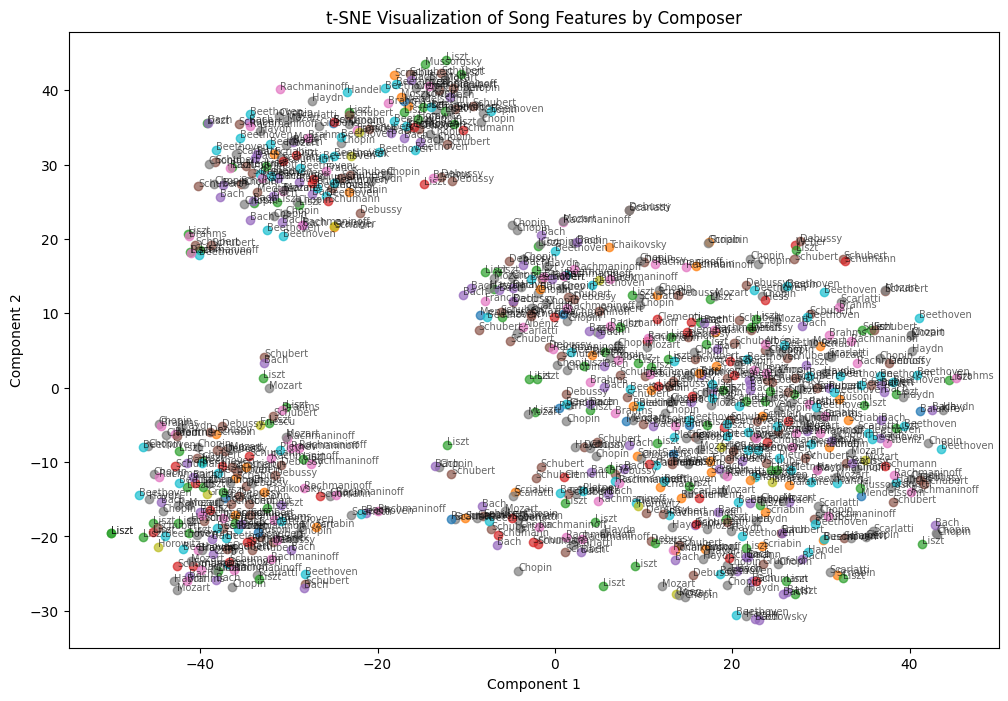

In [33]:
# Plot using Matplotlib with labels
plt.figure(figsize=(12, 8))

# Scatter plot for composers, colored by unique composers
for composer in df['composer'].unique():
    subset = df[df['composer'] == composer] #apellido
    plt.scatter(subset['x'], subset['y'], label=composer, alpha=0.7)

# Add labels to each point
for i in range(len(df)):
    plt.text(df['x'][i], df['y'][i], df['composer'][i].split()[-1], fontsize=7, alpha=0.6)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization of Song Features by Composer')
plt.savefig('imgs/fig2.png')

plt.show()


In [22]:
# Group by composer and calculate mean coordinates for each composer
composer_means = df.groupby('composer')[['x', 'y']].mean().reset_index()


In [23]:
def labeler(string):
    words = string.strip().split()
    if len(words) > 3 and len(words) < 5:
        return words[-3]+words[-1]
    elif len(words) > 5:
        return words[-4]+words[-1]
    else:
        return words[-1]

Plot average composer positions

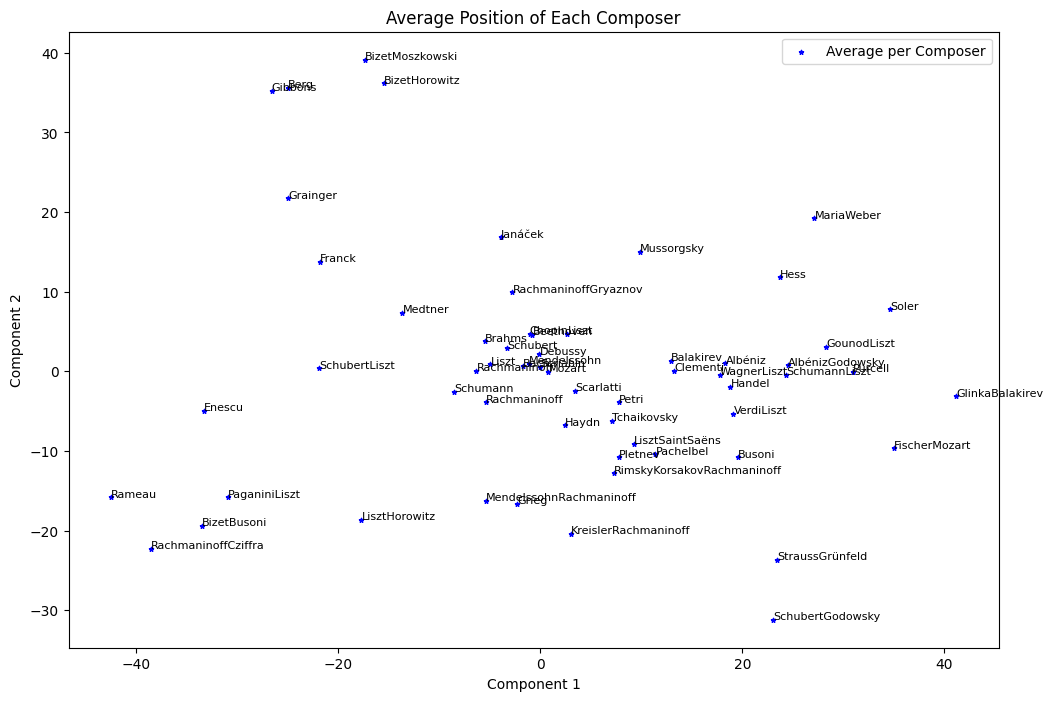

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot the average position of each composer
plt.scatter(composer_means['x'], composer_means['y'], color='blue', marker='*', s=10, label='Average per Composer')

# Annotate each average point with the composer's name
for i in range(len(composer_means)):
    plt.text(composer_means['x'][i] + 0.02, composer_means['y'][i] + 0.02, labeler(composer_means['composer'][i]), fontsize=8)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Average Position of Each Composer')
plt.legend()
plt.savefig('imgs/fig3.png')
plt.show()


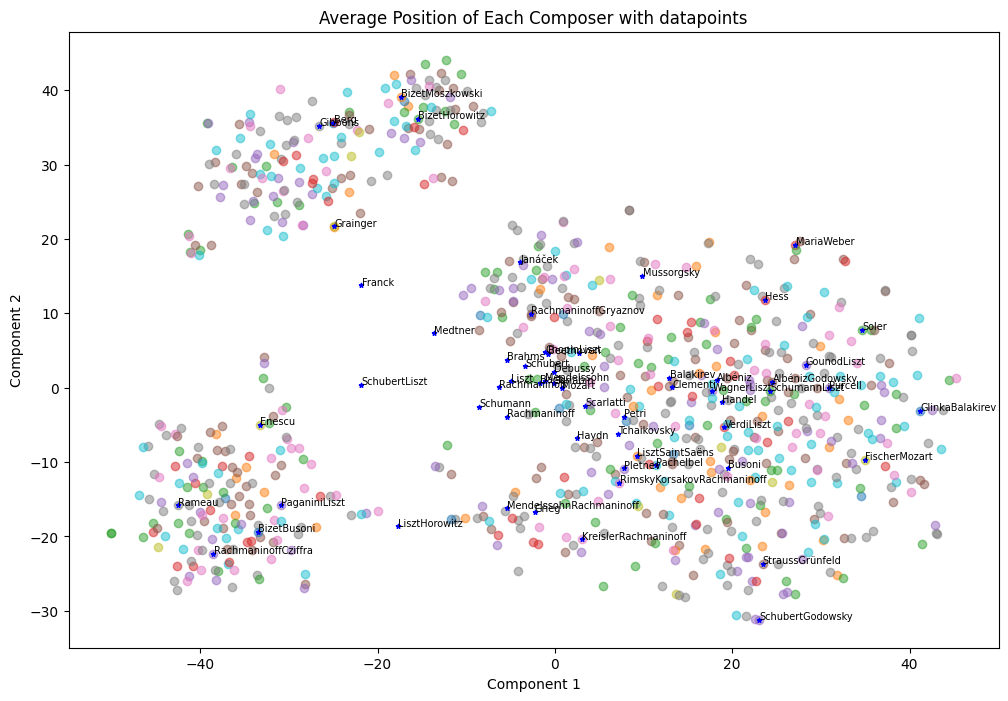

In [35]:
plt.figure(figsize=(12, 8))

# Plot all the songs and draw lines connecting each song to the composer's average
for composer in df['composer'].unique():
    subset = df[df['composer'] == composer]
    avg_x, avg_y = composer_means[composer_means['composer'] == composer][['x', 'y']].values[0]
    
    # Plot each song
    plt.scatter(subset['x'], subset['y'], alpha=0.5, label=f'Songs of {composer}')
    
# Plot the average position of each composer
plt.scatter(composer_means['x'], composer_means['y'], color='blue', marker='*', s=10, label='Average per Composer')

# Annotate each average point with the composer's name
for i in range(len(composer_means)):
    plt.text(composer_means['x'][i] + 0.02, composer_means['y'][i] + 0.02, labeler(composer_means['composer'][i]), fontsize=7)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Average Position of Each Composer with datapoints')
plt.savefig('imgs/fig4.png')
#plt.legend()
plt.show()


## Individual Composers

Restricted to >4 compositions in the dataset

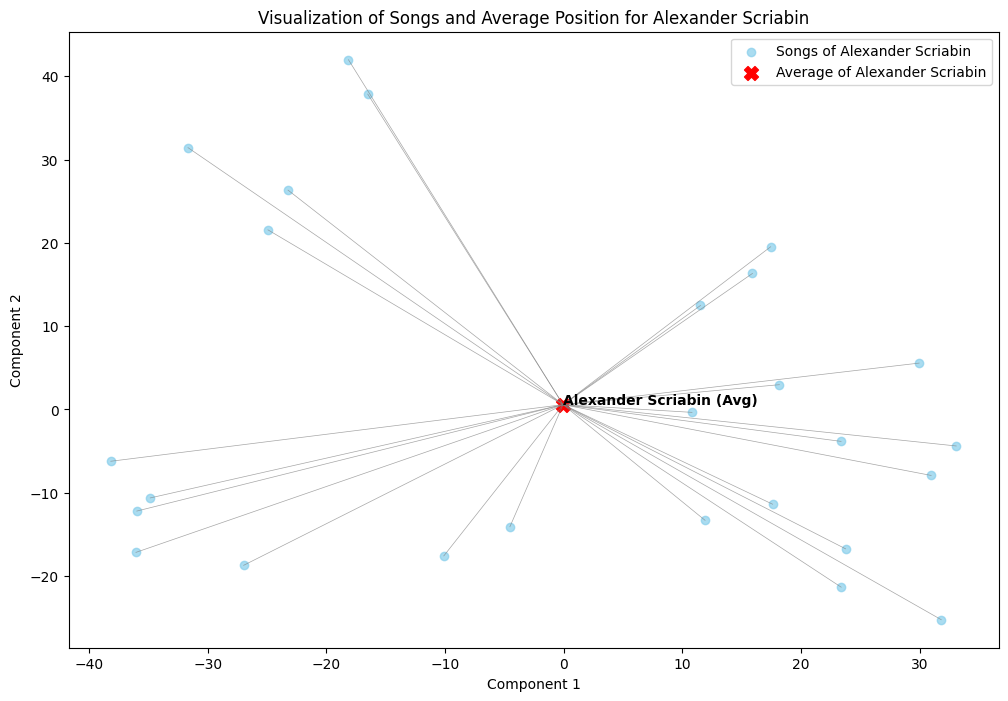

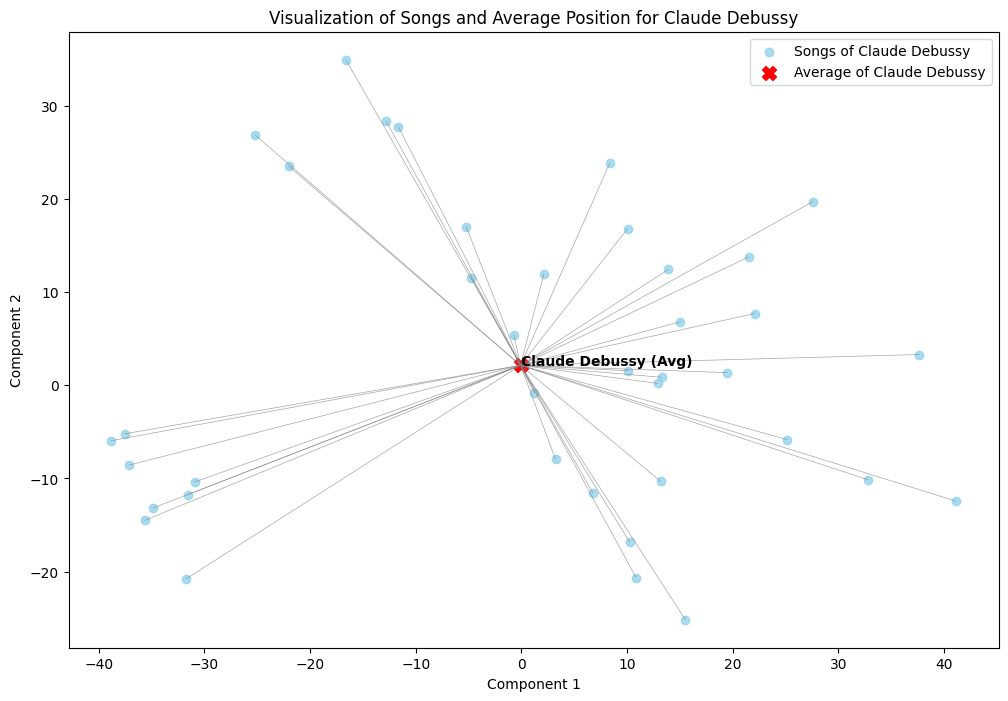

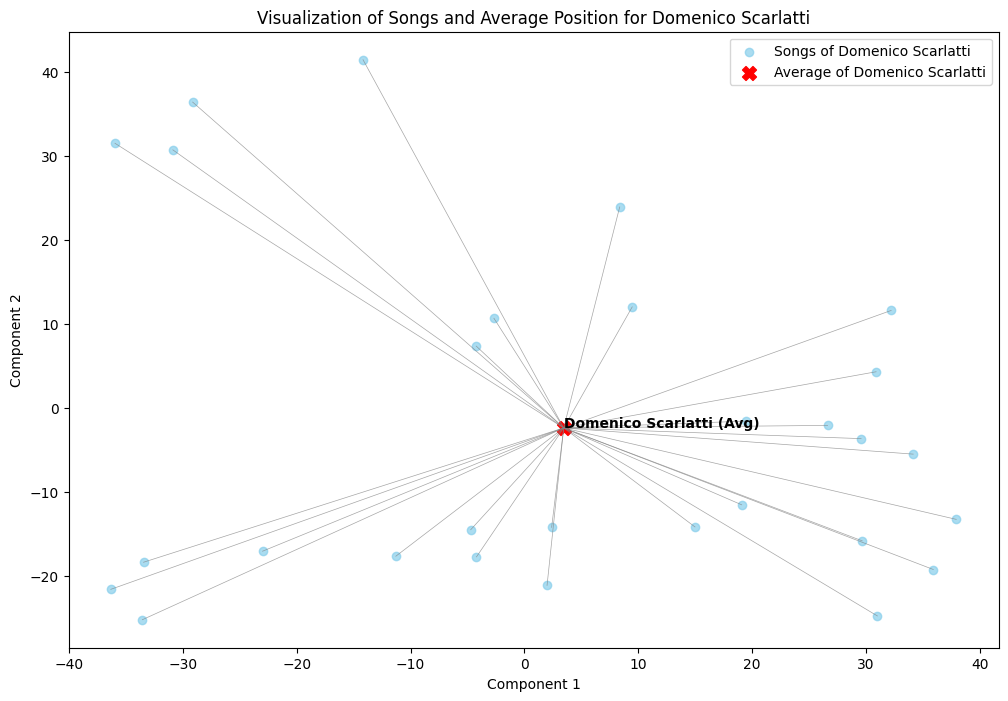

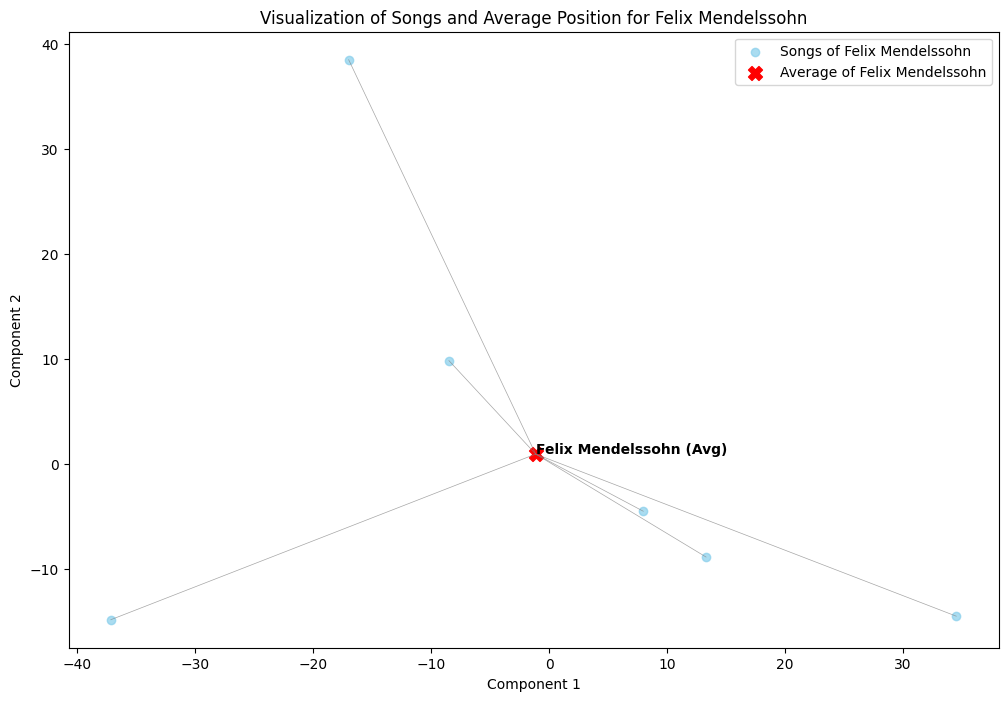

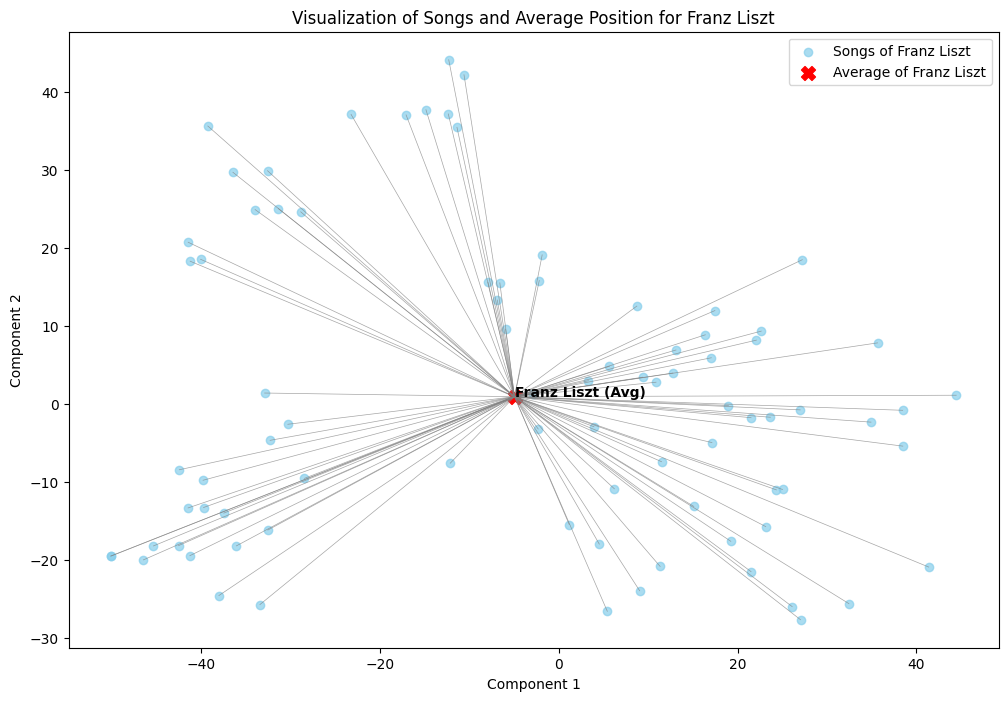

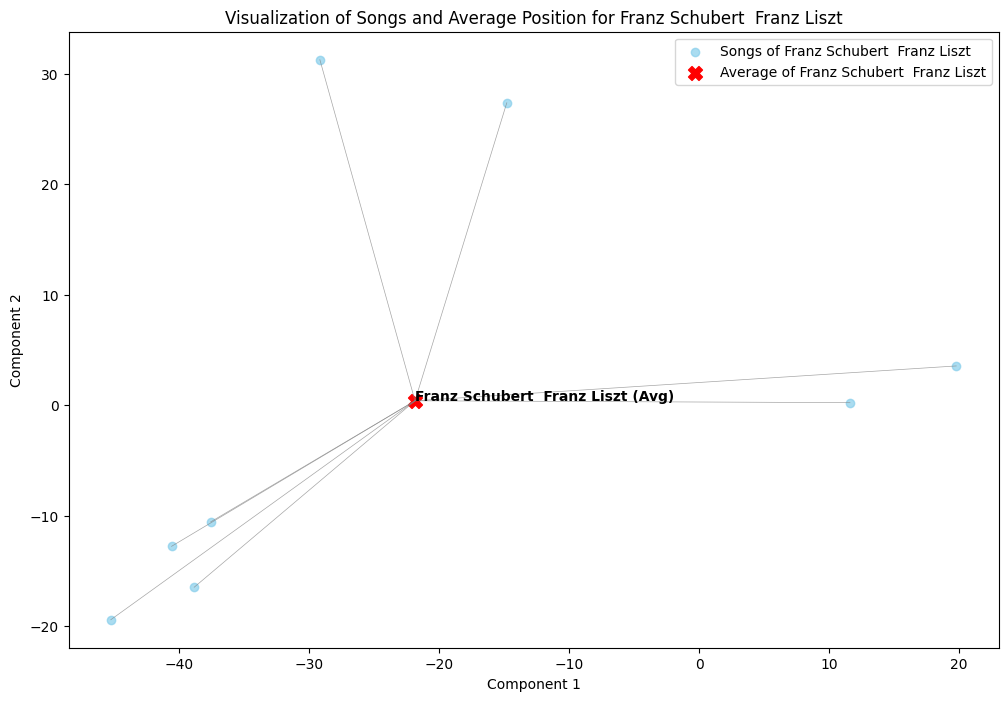

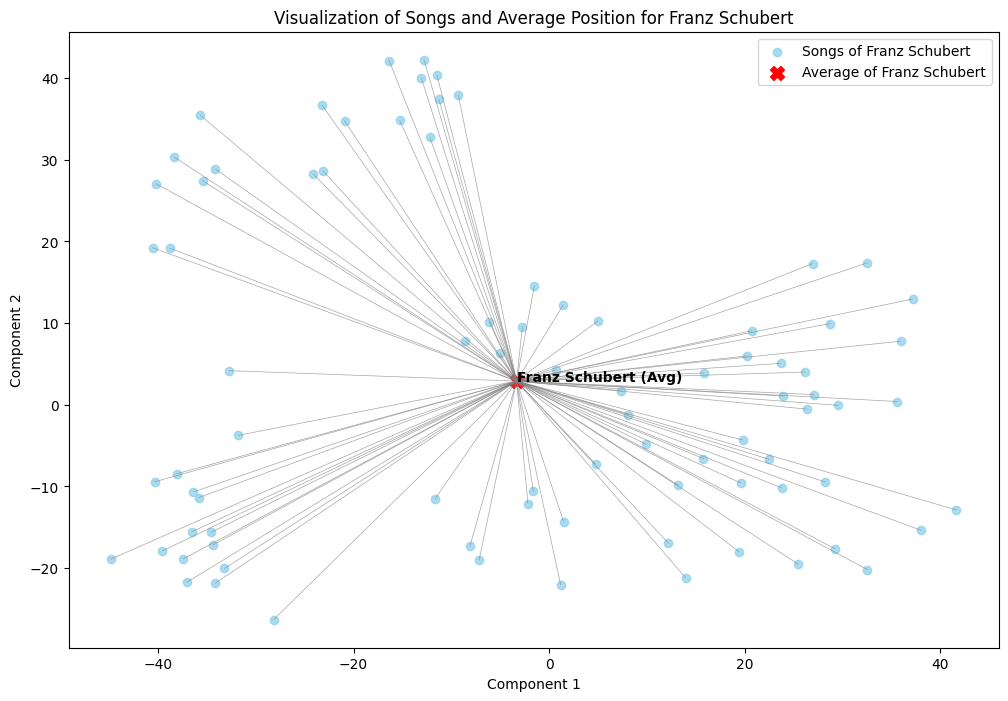

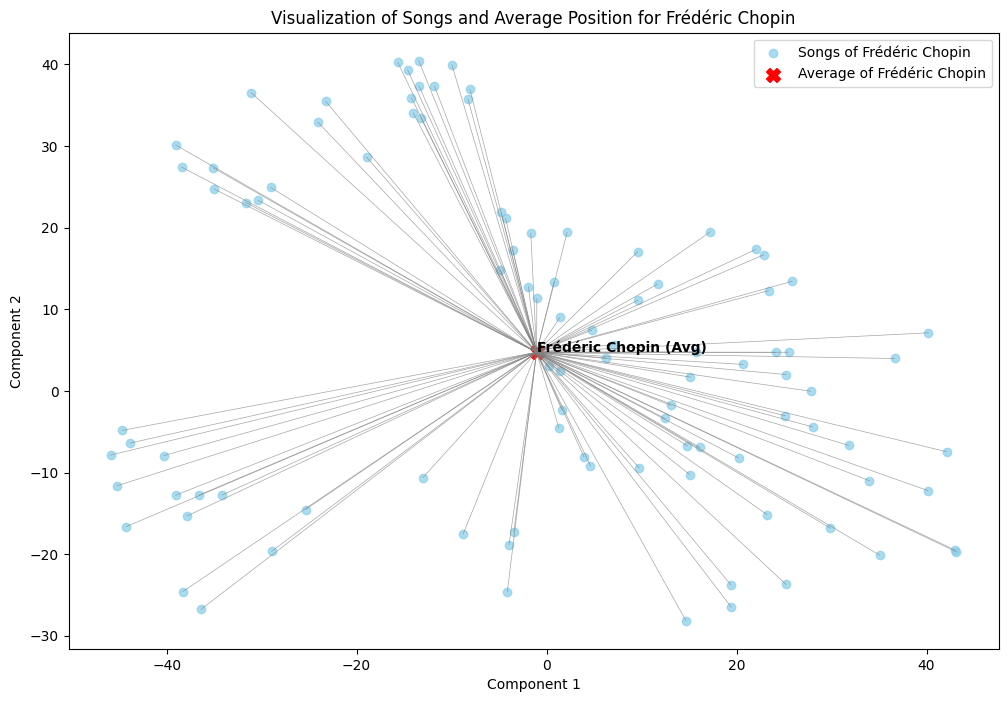

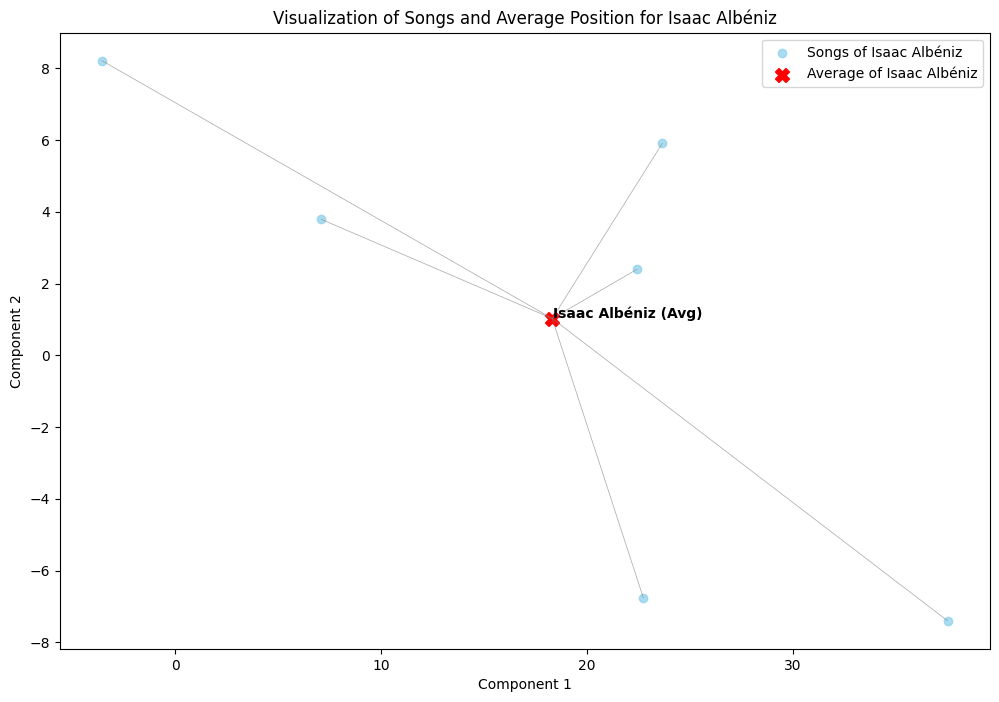

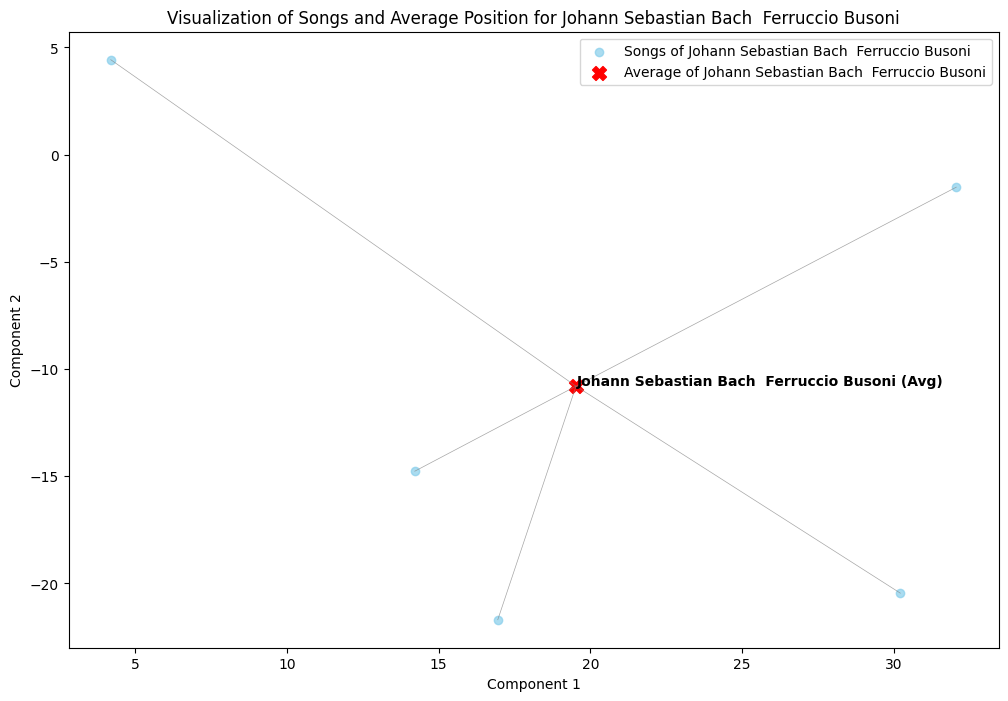

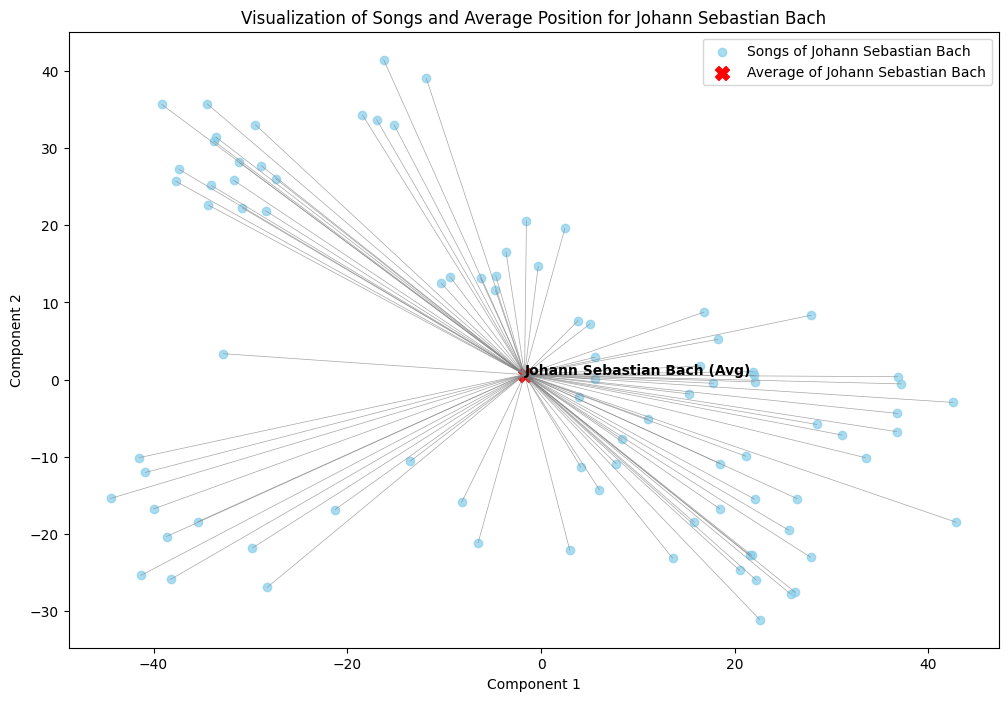

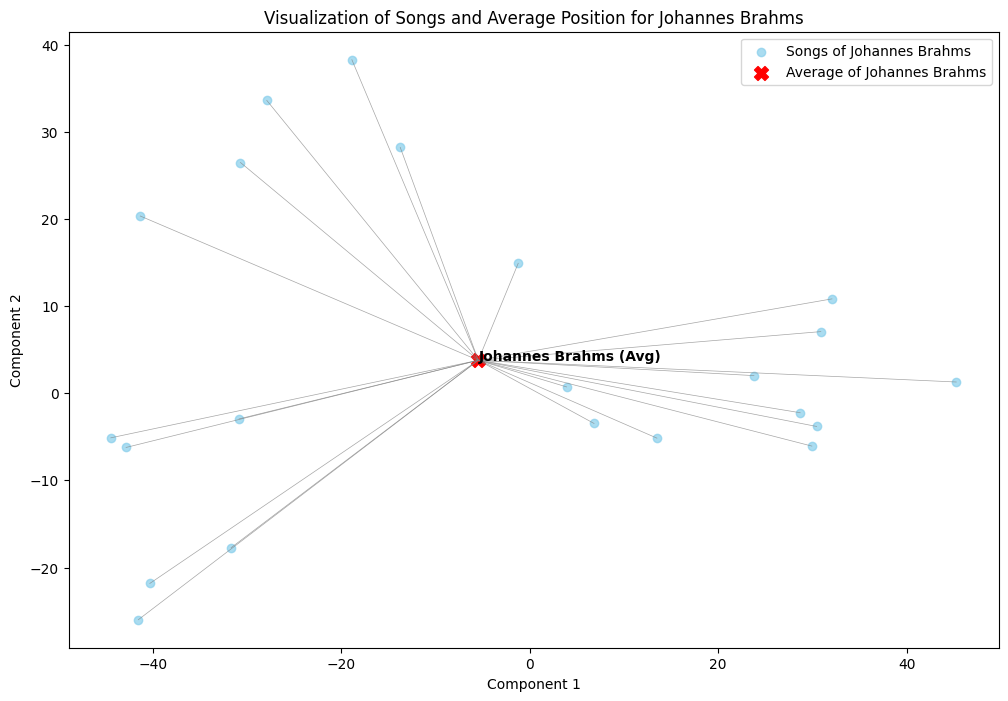

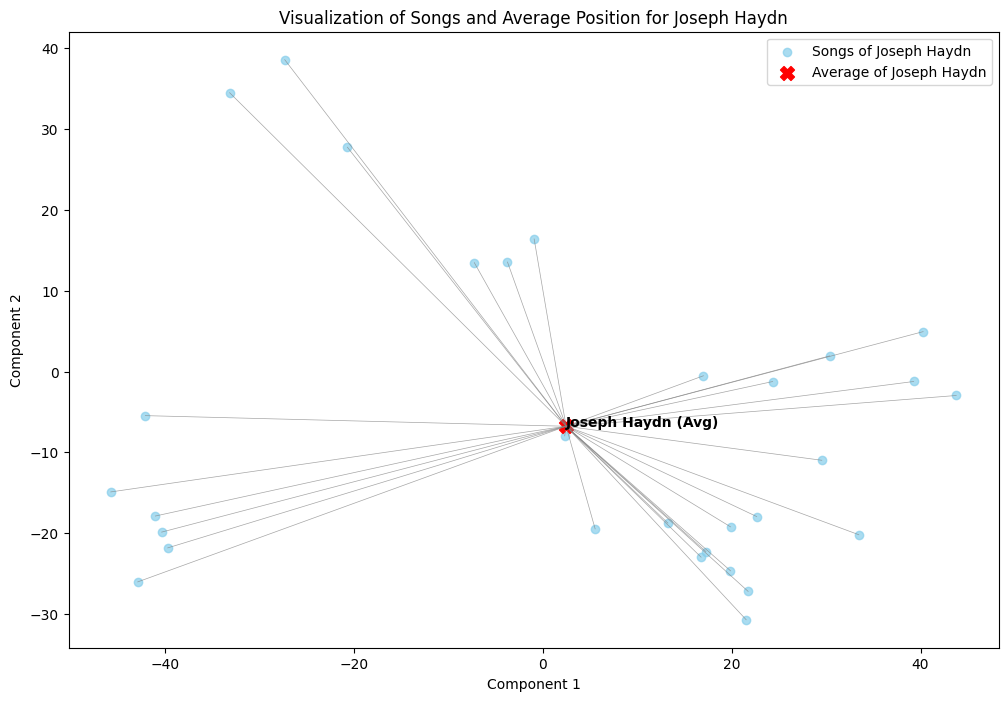

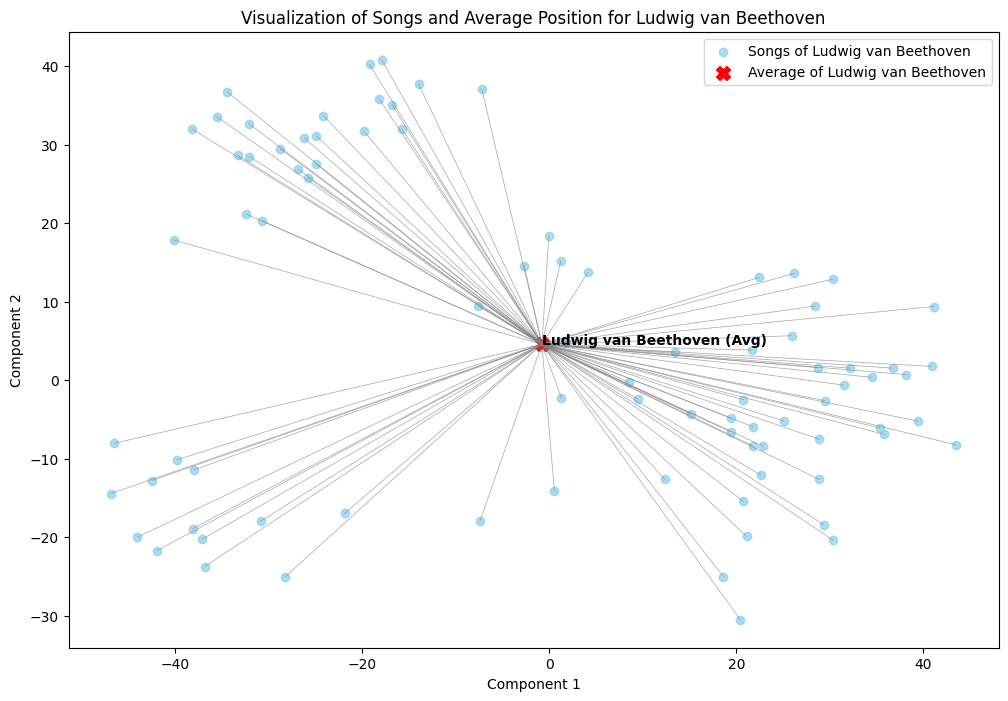

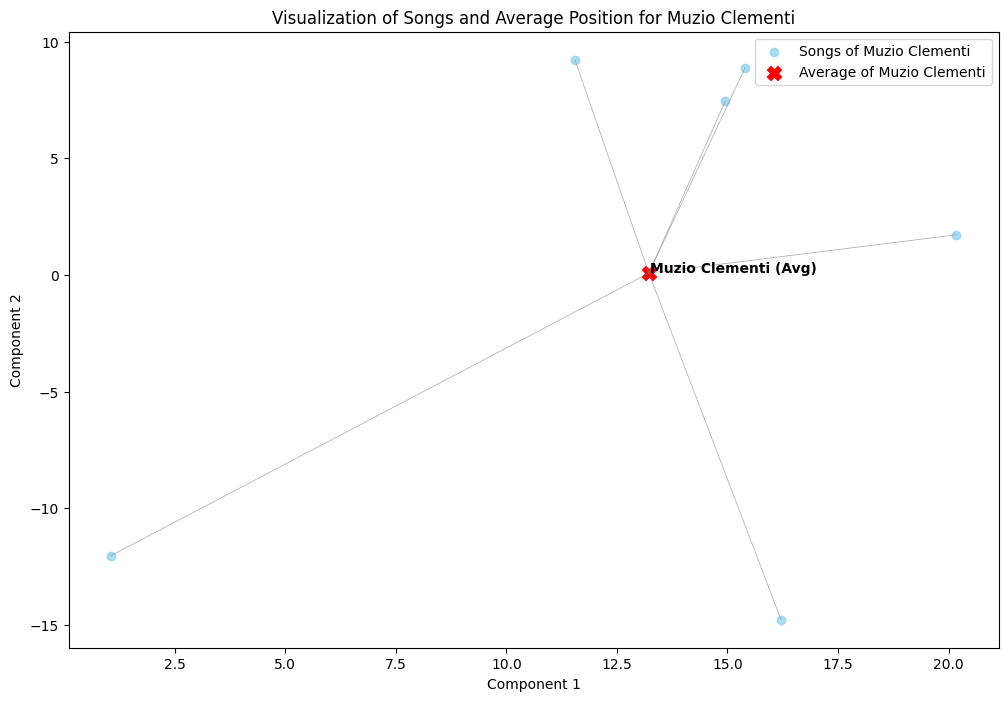

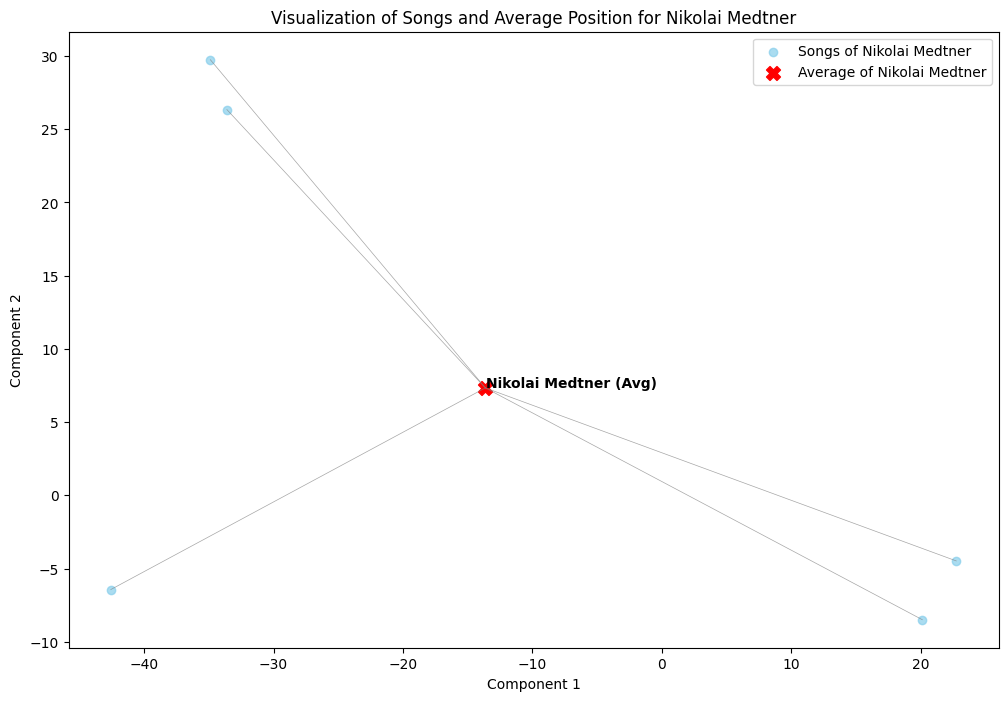

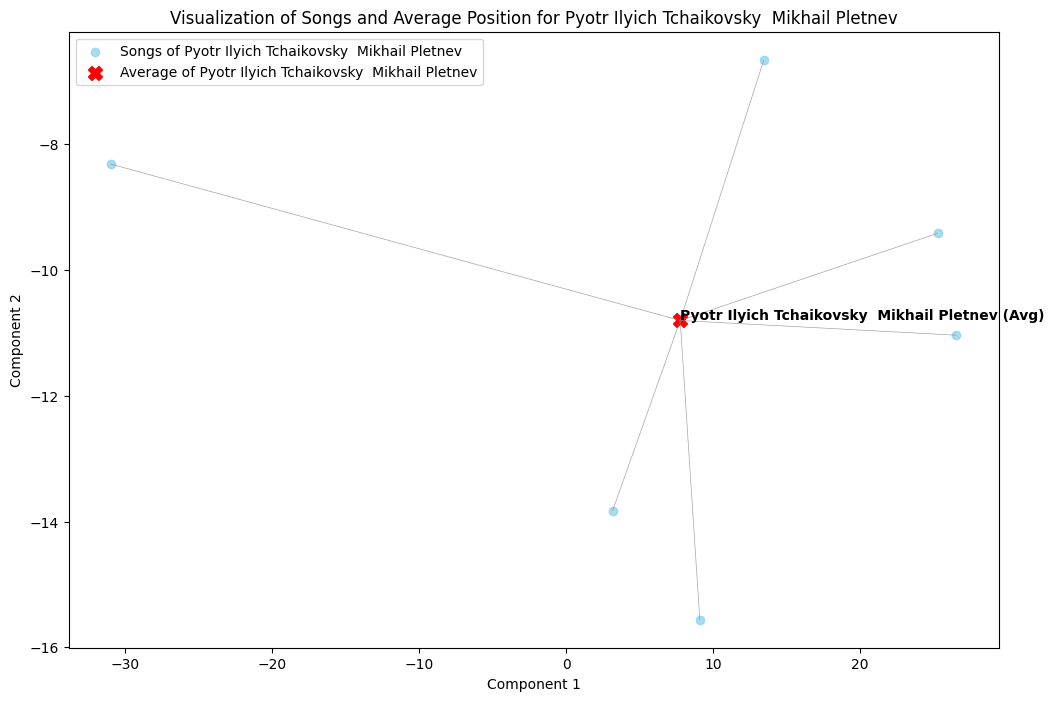

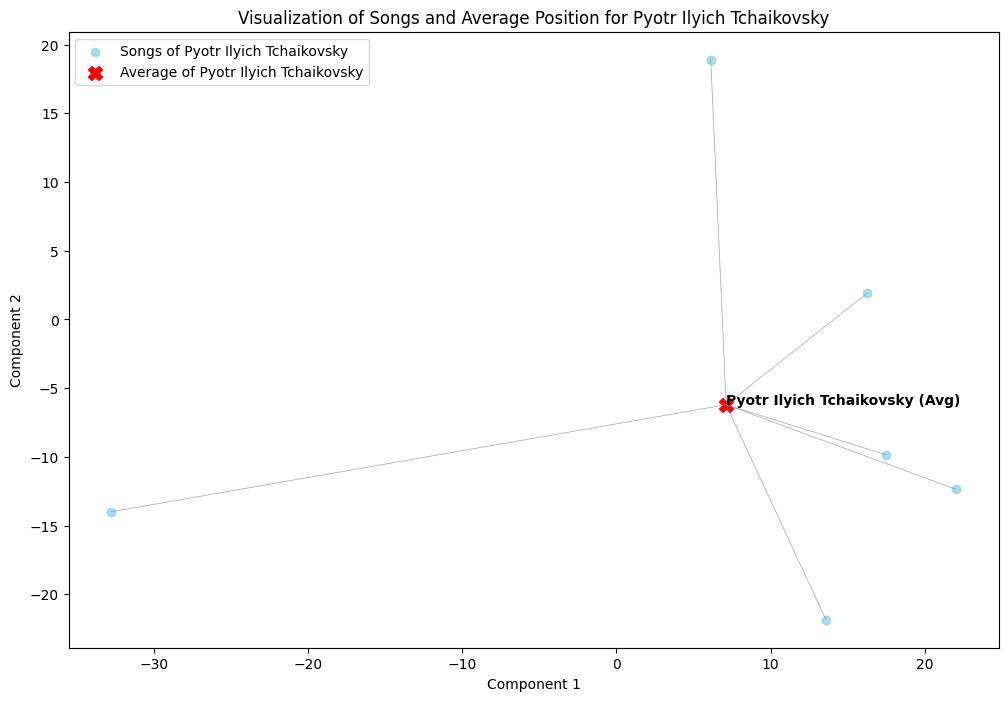

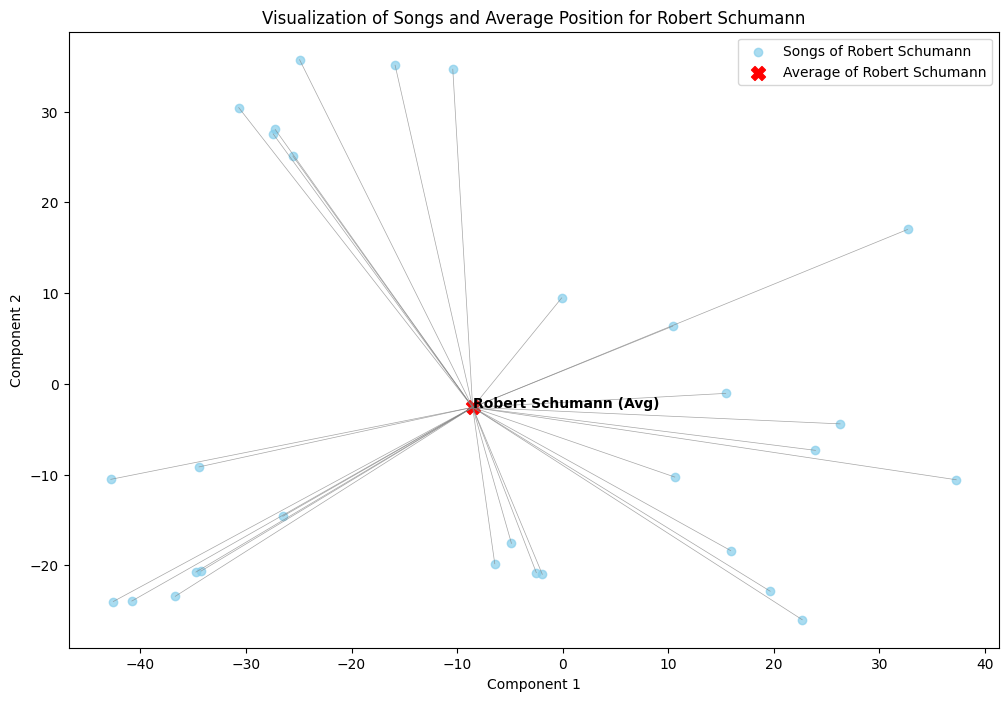

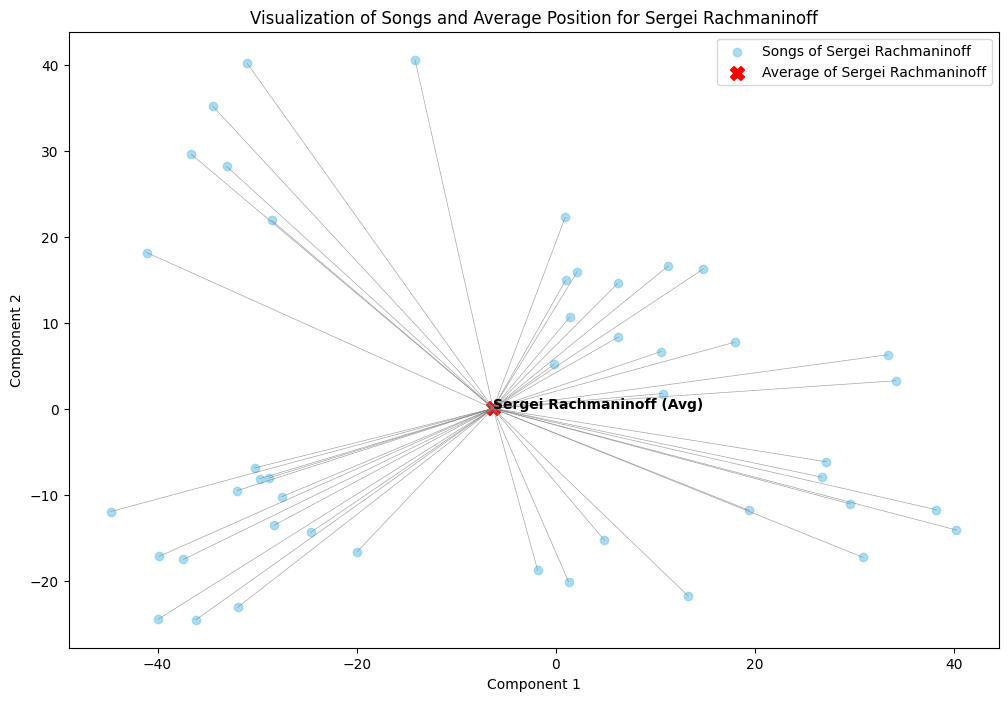

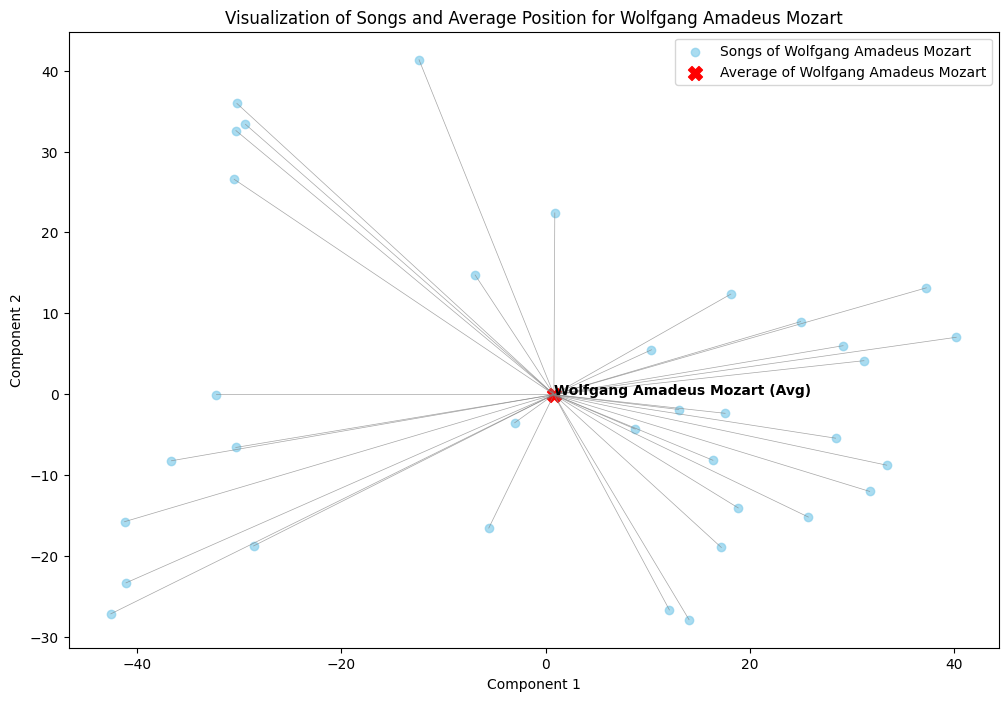

In [36]:
# Iterate over all composers in the dataset
for composer_name in df['composer'].unique():
    
    # Filter data for the specific composer
    composer_subset = df[df['composer'] == composer_name]
    if len(composer_subset) > 4:
        # Get the average position of the specific composer
        composer_avg = composer_means[composer_means['composer'] == composer_name]
        avg_x, avg_y = composer_avg[['x', 'y']].values[0]

        plt.figure(figsize=(12, 8))

        # Plot each song of the selected composer
        plt.scatter(composer_subset['x'], composer_subset['y'], color='skyblue', alpha=0.7, label=f'Songs of {composer_name}')

        # Draw lines from each song to the average
        for i in range(len(composer_subset)):
            plt.plot([composer_subset['x'].iloc[i], avg_x], [composer_subset['y'].iloc[i], avg_y], color='gray', linestyle='-', linewidth=0.5, alpha=0.7)

        # Plot the average position of the composer
        plt.scatter(avg_x, avg_y, color='red', marker='X', s=100, label=f'Average of {composer_name}')

        # Annotate the average point with the composer's name
        plt.text(avg_x + 0.02, avg_y + 0.02, f'{composer_name} (Avg)', fontsize=10, fontweight='bold')

 
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.title(f'Visualization of Songs and Average Position for {composer_name}')
        plt.legend()
        plt.savefig(f'imgs/composer_{composer_name}.png')
    
        plt.show()


## Aditional plots

Not very informative

### Clustering

In [41]:
from sklearn.cluster import KMeans

# Define the number of clusters. You might start with the number of unique composers
n_clusters = len(df['composer'].unique())

# Apply K-Means clustering on the original feature set or the reduced features
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

# Add cluster labels to the DataFrame for visualization
df['cluster'] = clusters


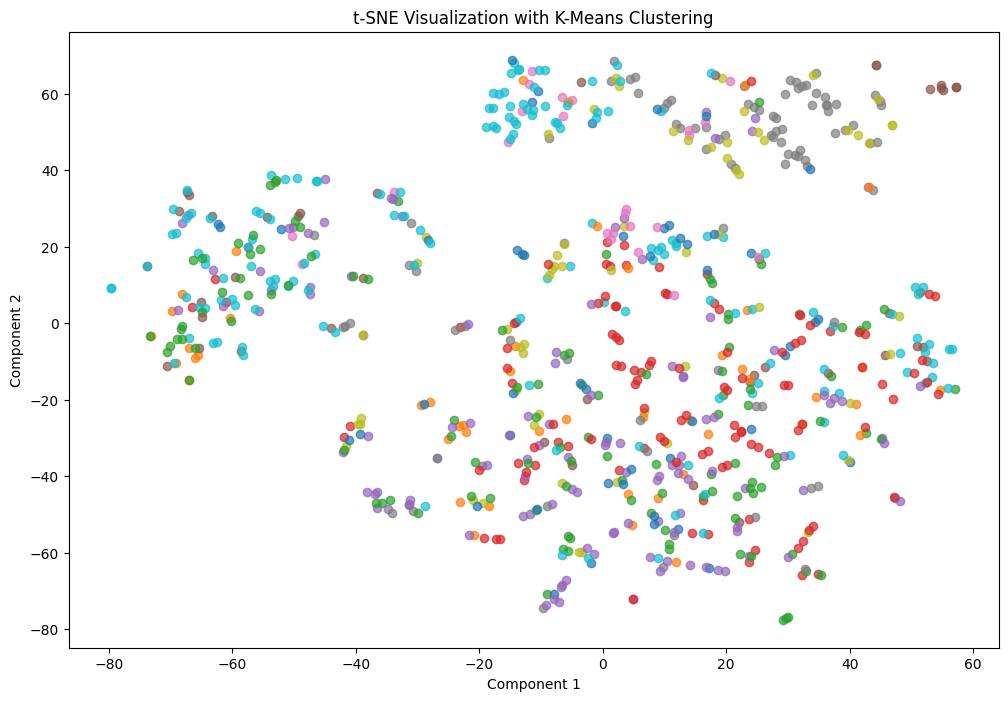

In [42]:
plt.figure(figsize=(12, 8))
for cluster_id in range(n_clusters):
    subset = df[df['cluster'] == cluster_id]
    plt.scatter(subset['x'], subset['y'], label=f'Cluster {cluster_id}', alpha=0.7)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization with K-Means Clustering')
#plt.legend()
plt.show()


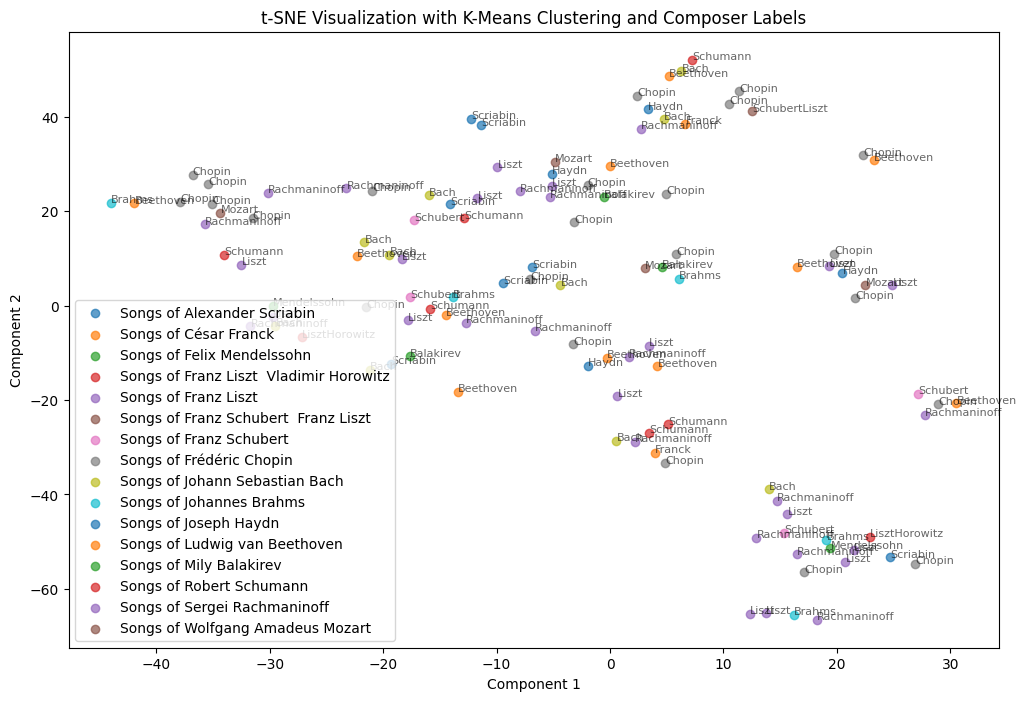

In [61]:
plt.figure(figsize=(12, 8))

# Plot the clusters with composer names
for composer in df['composer'].unique():
    subset = df[df['composer'] == composer]
    plt.scatter(subset['x'], subset['y'], label=f'Songs of {composer}', alpha=0.7)

# Annotate each point with the composer's name
for i in range(len(df)):
    plt.text(df['x'][i] + 0.02, df['y'][i] + 0.02, labeler(df['composer'][i]), fontsize=8, alpha=0.6)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization with K-Means Clustering and Composer Labels')
plt.legend()
plt.show()


### Distances

In [39]:
from scipy.spatial.distance import pdist, squareform

# Calculate the pairwise distances between all features
distance_matrix = pdist(features, metric='euclidean')

# Convert to a square matrix form for easier interpretation
distance_matrix_square = squareform(distance_matrix)

# Display as a pandas DataFrame for better readability
import pandas as pd

distance_df = pd.DataFrame(distance_matrix_square, index=labels, columns=labels)

# Optionally, print or explore specific distances
print(distance_df)


                           Alban Berg  Alexander Scriabin  Alexander Scriabin  \
Alban Berg                   0.000000        22711.228148        23038.443632   
Alexander Scriabin       22711.228148            0.000000        22436.048159   
Alexander Scriabin       23038.443632        22436.048159            0.000000   
Alexander Scriabin       22769.996750        22194.898243        22538.470512   
Alexander Scriabin       22973.879233        23475.747507        23427.387690   
...                               ...                 ...                 ...   
Wolfgang Amadeus Mozart  22668.410354        22408.787607        22197.923799   
Wolfgang Amadeus Mozart  22926.809307        23464.641804        22919.393578   
Wolfgang Amadeus Mozart  22805.162530        24150.669929        24189.782947   
Wolfgang Amadeus Mozart  22715.082809        22176.802452        21848.020917   
Wolfgang Amadeus Mozart  23046.081880        23465.385401        23117.194488   

                         Al

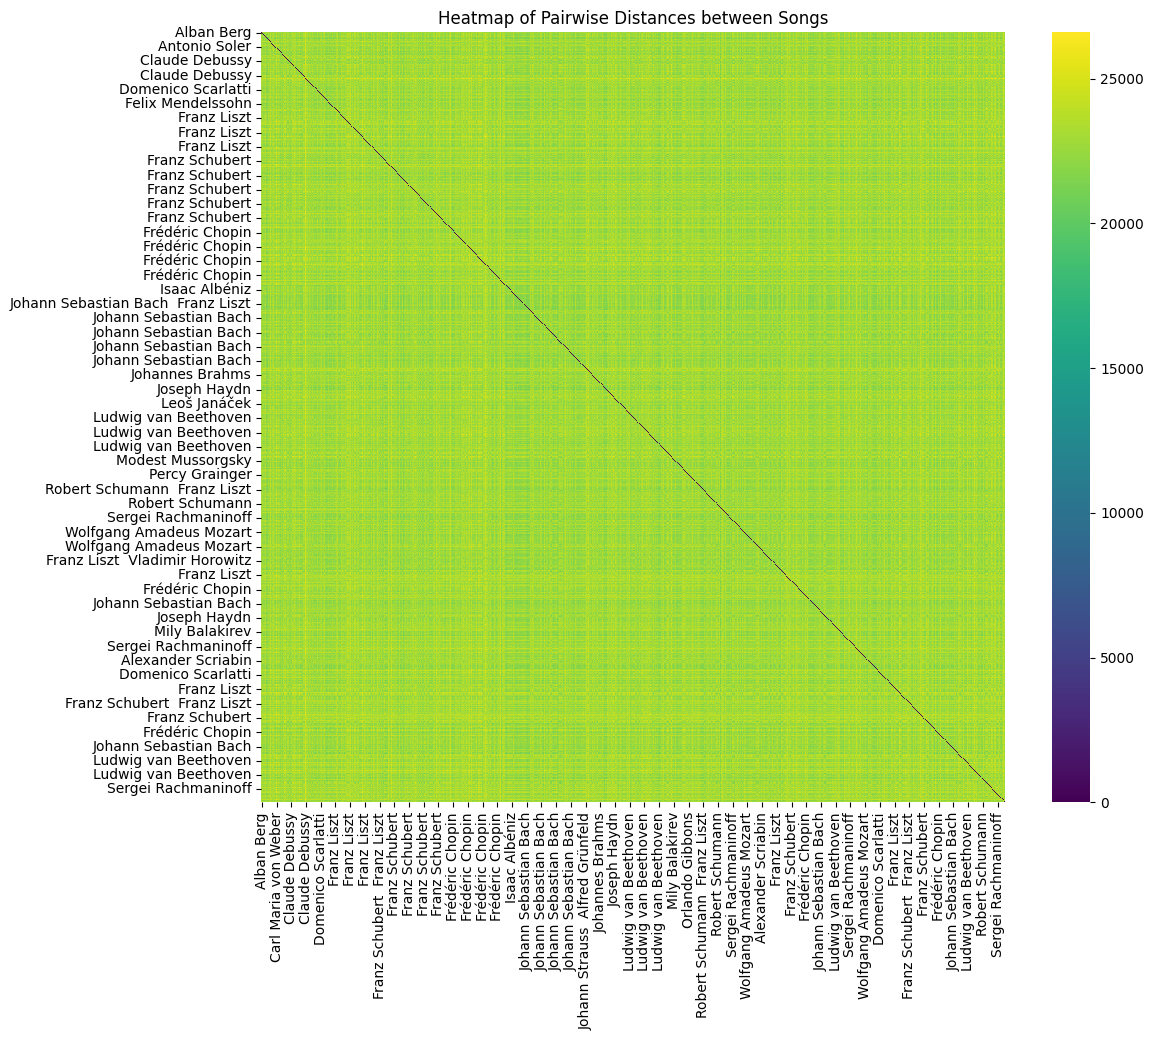

In [40]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(distance_df, cmap='viridis')
plt.title('Heatmap of Pairwise Distances between Songs')
plt.show()
